Lambda School Data Science

*Unit 4, Sprint 1, Module 3*

---

# Document Classification (Lecture)

Today's guided module project will be different. You already know how to do classification. You ready know how to extract features from documents. So? That means you're ready to combine and practice those skills in a kaggle competition. We we will open with a five minute sprint explaining the competition, and then give you 25 minutes to work. After those twenty five minutes are up, I will give a 5-minute demo an NLP technique that will help you with document classification (*and **maybe** the competition*).

Today's all about having fun and practicing your skills. The competition will begin

## Learning Objectives
* <a href="#p1">Part 1</a>: Text Feature Extraction & Classification Pipelines
* <a href="#p2">Part 2</a>: Latent Semantic Indexing
* <a href="#p3">Part 3</a>: Word Embeddings with Spacy

# Text Feature Extraction & Classification Pipelines (Learn)
<a id="p1"></a>

## Overview

Sklearn pipelines allow you to stitch together multiple components of a machine learning process. The idea is that you can pass you raw data and get predictions out of the pipeline. This ability to pass raw input and receive a prediction from a singular class makes pipelines well suited for production, because you can pickle a a pipeline without worry about other data preprocessing steps. 

*Note:* Each time we call the pipeline during grid search, each component is fit again. The vectorizer (tf-idf) is transforming our entire vocabulary during each cross-validation fold. That transformation adds significant run time to our grid search. There *might* be interactions between the vectorizer and our classifier, so we estimate their performance together in the code below. However, if your goal is to reduce run time. Train your vectorizer separately (ie out of the grid-searched pipeline). 

In [1]:
# Import Statements
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

### Load Data

In [2]:
# Dataset
from sklearn.datasets import fetch_20newsgroups

categories = ['sci.electronics',
              'talk.politics.misc']

# Load training data
newsgroups_train = fetch_20newsgroups(subset='train', 
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

# Load testing data
newsgroups_test = fetch_20newsgroups(subset='test', 
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

print(f'Training Samples: {len(newsgroups_train.data)}')
print(f'Testing Samples: {len(newsgroups_test.data)}')

Training Samples: 1056
Testing Samples: 703


In [3]:
print(newsgroups_train.data[10])


The father of a friend of mine is a police officer in West Virginia.  Not  
only is his word as a skilled observer good in court, but his skill as an  
observer has been tested to be more accurate than the radar gun in some  
cases . . ..  No foolin!  He can guess a car's speed to within 2-3mph just  
by watching it blow by - whether he's standing still or moving too!  (Yes,  
I realize that calibrated guns are more accurate than this, but . . .).   
His ability is not that uncommon among people who watch moving things for a  
living, I have heard . . ..

So what good is a radar detector except to give you a split second warning  
that the guy who just cut you off to pass the guy ahead and to your left  
is about to panic stop from 85 on a crowded freeway???


In [4]:
newsgroups_train.target[10]

0

In [5]:
newsgroups_train.target_names[0]

'sci.electronics'

### Explore the Data

Building and training a model is only one part of the workflow. Understanding the basic characteristics of your data beforehand will enable you to build a better model. This could mean obtaining higher accuracy, requiring less data for training, or potentially fewer computation resources. 

In [6]:
from explore_data import *
import seaborn as sns
sns.set()

In [7]:
median_words_per_sample = get_num_words_per_sample(newsgroups_train.data)
print(f'Median words per sample: {median_words_per_sample}')

Median words per sample: 91.0


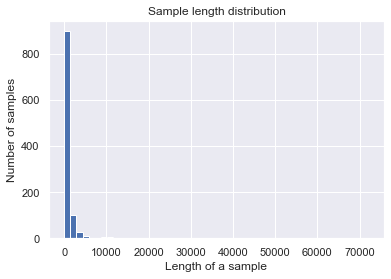

In [8]:
plot_sample_length_distribution(newsgroups_train.data)

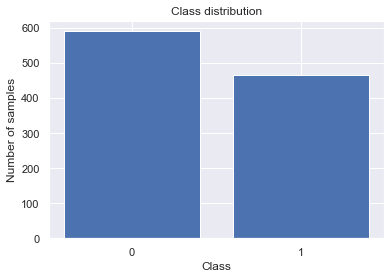

In [9]:
plot_class_distribution(newsgroups_train.target)

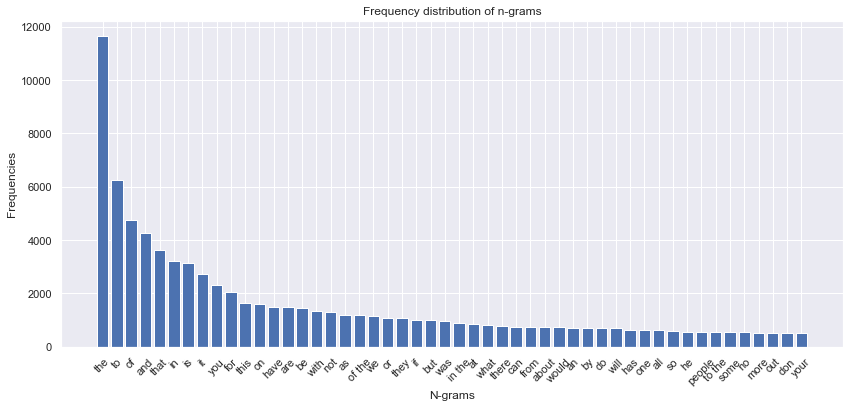

In [10]:
plot_frequency_distribution_of_ngrams(newsgroups_train.data,
                                      ngram_range=(1, 2),
                                      num_ngrams=50)

### Choose a Modeling Approach

Reference: https://developers.google.com/machine-learning/guides/text-classification/step-2-5

At this point, we have assembled our dataset and gained insights into the key characteristics of our data. Next, based on the metrics we gathered we should think about which classification model we should use. This means asking questions such as: 

- “How do we present the text data to an algorithm that expects numeric input?” (Data preprocessing and vectorization)
- “What type of model should we use?”
- “What configuration parameters should we use for our model?”, etc.

In the reference guide above, Google attempts to significantly simplify the process of selecting a text classification model. For a given dataset, our goal is to find the algorithm that achieves close to maximum accuracy while minimizing computation time required for training. We ran a large number (~450K) of experiments across problems of different types (especially sentiment analysis and topic classification problems), using 12 datasets, alternating for each dataset between different data preprocessing techniques and different model architectures. This helped us identify dataset parameters that influence optimal choices.

The model selection algorithm and flowchart below are a summary of our experimentation.

In [11]:
sw_ratio = len(newsgroups_train.data) / median_words_per_sample
print(f'Number of Samples / Median Words per Sample ratio: {int(sw_ratio)}')

Number of Samples / Median Words per Sample ratio: 11


![](https://developers.google.com/machine-learning/guides/text-classification/images/TextClassificationFlowchart.png)

### Build a Baseline TF-IDF Model

In [12]:
# Create Pipeline Components
vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
rfc = RandomForestClassifier()

In [13]:
import pandas as pd

# Get sparse dtm
dtm = vect.fit_transform(newsgroups_train.data)

# Convert to dataframe
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.shape

(1056, 97372)

In [14]:
# Define the Pipeline
pipe = Pipeline([
    ('vect', vect),      # TF-IDF Vectorizer
    ('clf', rfc)         # RandomForest Classifier
])

In [15]:
parameters = {
    'vect__max_df': (0.7, 1.0),
    'vect__min_df': (2, 5, 10),
    'vect__max_features': (5000, 10000),
    'clf__n_estimators': (100, 500),
    'clf__max_depth': (10, 20, None)
}

grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(newsgroups_train.data, newsgroups_train.target)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__max_df': (0.7, 1.0), 'vect__min_df': (2, 5, 10), 'vect__max_features': (5000, 10000), 'clf__n_estimators': (100, 500), 'clf__max_depth': (10, 20, None)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [16]:
grid_search.best_score_

0.90625

In [17]:
grid_search.best_params_

{'clf__max_depth': None,
 'clf__n_estimators': 100,
 'vect__max_df': 0.7,
 'vect__max_features': 10000,
 'vect__min_df': 2}

In [18]:
from sklearn.metrics import accuracy_score

# Evaluate on test data
y_test = grid_search.predict(newsgroups_test.data)
accuracy_score(newsgroups_test.target, y_test)

0.8862019914651493

## Follow Along 

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model (try using the pipe method I just demoed)

## Challenge

You're trying to achieve 75% Accuracy on your model.

## Latent Semantic Indexing (Learn)
<a id="p2"></a>

## Overview

In [19]:
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD

# Use parameters from RandomSearch in previous section
vect = TfidfVectorizer(stop_words='english', 
                       ngram_range=(1,2),
                       min_df=2, 
                       max_df=0.7,
                       max_features=10000)

# Add dimensionality reduction
svd = TruncatedSVD(algorithm='randomized',
                   n_iter=10)

# Use parameters from RandomSearch in previous section
rfc = RandomForestClassifier(n_estimators=500, 
                             random_state=42)

In [20]:
params = {
    'svd__n_components': stats.randint(100, 500),
}

In [21]:
pipe = Pipeline([
    ('vect', vect),      # TF-IDF Vectorizer
    ('svd', svd),        # Truncated SVD Dimensionality Reduction
    ('clf', rfc)         # RandomForest Classifier
])

In [22]:
# Fit
random_search = RandomizedSearchCV(pipe, params, cv=2, n_iter=3, n_jobs=-1, verbose=1)
random_search.fit(newsgroups_train.data, newsgroups_train.target)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  1.7min remaining:   50.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.7min finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=10000, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,...ators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=3, n_jobs=-1,
          param_distributions={'svd__n_components': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002360F7DB438>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [23]:
random_search.best_score_

0.9195075757575758

In [24]:
random_search.best_params_

{'svd__n_components': 156}

In [25]:
# Evaluate on test data
y_test = random_search.predict(newsgroups_test.data)
accuracy_score(newsgroups_test.target, y_test)

0.9274537695590327

## Follow Along
1. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
2. Make a submission to Kaggle 


## Challenge

Continue to apply Latent Semantic Indexing (LSI) to various datasets. 

# Word Embeddings with Spacy (Learn)
<a id="p3"></a>

# Overview

In [26]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [27]:
doc = nlp("NLP is awesome!")

In [28]:
nlp_vector = doc.vector
print(len(nlp_vector))

300


In [29]:
nlp_vector

array([-1.99885249e-01,  3.45714986e-01,  1.64885744e-02, -2.35542506e-02,
        1.43662512e-01, -1.23924986e-02,  1.52034998e-01, -3.65224987e-01,
        1.13594748e-01,  1.15108001e+00, -1.83196187e-01,  2.74120513e-02,
       -1.02375746e-01,  3.13747525e-02,  4.55302559e-02, -1.85307249e-01,
       -1.46043763e-01,  9.30569947e-01, -2.01018006e-01, -2.33615756e-01,
        4.34175134e-03, -6.69924989e-02,  6.06357455e-02, -1.58095673e-01,
       -9.37802419e-02,  1.93459496e-01,  1.92345500e-01, -5.94324991e-02,
        1.68709978e-02, -1.27937496e-01,  6.42787516e-02, -3.23557481e-02,
        1.33825943e-01,  1.85234249e-01,  6.99924976e-02,  1.28265738e-01,
        2.38190234e-01,  1.21133000e-01, -2.19828337e-01, -2.38023698e-01,
        1.51863992e-01, -9.34367478e-02, -1.61462426e-02,  1.24664992e-01,
        2.68729985e-01,  3.37404758e-01, -2.72237003e-01,  2.25244984e-02,
        5.79980016e-02, -1.66924000e-01,  1.35736749e-01,  1.77590013e-01,
        4.06724960e-02, -

In [30]:
def get_word_vectors(docs):
    return [nlp(doc).vector for doc in docs]

In [31]:
X = get_word_vectors(newsgroups_train.data)
len(X) == len(newsgroups_train.data)

True

In [32]:
X_test = get_word_vectors(newsgroups_test.data)

In [33]:
rfc.fit(X, newsgroups_train.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [34]:
# Evaluate on test data
y_test = rfc.predict(X_test)
accuracy_score(newsgroups_test.target, y_test)

0.930298719772404

In [35]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5,
                    hidden_layer_sizes=(16, 2),
                    random_state=1)

In [36]:
clf.fit(X, newsgroups_train.target)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(16, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [37]:
# Evaluate on test data
y_test = clf.predict(X_test)
accuracy_score(newsgroups_test.target, y_test)

0.930298719772404

## Follow Along

## Challenge

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

# Review

To review this module: 
* Continue working on the Kaggle competition
* Find another text classification task to work on